# XGBoost regressor model 

In [43]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

In [2]:
# Set max number of columns to display; default 20
pd.options.display.max_columns = 50

In [70]:
# Paths to data directories
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

#### Read in data (and wrangle a bit)

In [110]:
df = pd.read_pickle(data_push_path / 'df_main_smard_era5_final_reordered.pkl')

# split off SMARD forecasted and actuals into separate dataframe and drop SMARD forecasted
df_smard_preds_vs_actuals = df.loc[:, ['forecasted_generation_smard_mwh', 'actual_generated_smard_mwh']].copy()
df.drop(columns=['forecasted_generation_smard_mwh'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48168 entries, 2018-01-01 00:00:00+00:00 to 2023-06-30 23:00:00+00:00
Data columns (total 34 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   hour                                            48168 non-null  int32  
 1   day_of_week                                     48168 non-null  int32  
 2   day_of_month                                    48168 non-null  int32  
 3   day_of_year                                     48168 non-null  int32  
 4   week_of_year                                    48168 non-null  UInt32 
 5   month_number                                    48168 non-null  int32  
 6   year                                            48168 non-null  int32  
 7   meteorological_season                           48168 non-null  object 
 8   public_holiday                                  48168 non-null  int64

In [107]:
df.tail()

,hour,day_of_week,day_of_month,day_of_year,week_of_year,month_number,year,meteorological_season,public_holiday,turbines_in_operation,total_nominal_capacity_operational_turbines_mw,total_nominal_capacity_smard_mw,day_ahead_price_eur_mwh,total_net_load_smard_mwh,residual_load_smard_mwh,temp_2m_celsius,mean_sea_level_pressure_mb,wind_gusts_10m,mean_wind_speed_10m,mean_wind_speed_100m,wind_direction_angle_10m,wind_direction_angle_100m,wind_direction_intercardinal_10m,wind_direction_intercardinal_100m,weighted_temp_2m_celsius,weighted_mean_sea_level_pressure_mb,weighted_wind_gusts_10m,weighted_mean_wind_speed_10m,weighted_mean_wind_speed_100m,weighted_mean_wind_direction_angle_10m,weighted_mean_wind_direction_angle_100m,weighted_wind_direction_intercardinal_10m,weighted_wind_direction_intercardinal_100m,actual_generated_smard_mwh
datetime_utc,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-06-30 19:00:00+00:00,19,4,30,181,26,6,2023,summer,0,29412,59315.041337,57590.0,130.74,48794.25,44133.75,17.934381,1010.896875,3.549851,1.842328,3.449438,277.569061,278.582458,W,W,18.057953,1010.494333,3.268352,1.735454,3.298011,267.207132,272.506988,W,W,1698.75
2023-06-30 20:00:00+00:00,20,4,30,181,26,6,2023,summer,0,29412,59315.041337,57590.0,122.39,46764.00,41337.00,16.834222,1011.285156,3.295196,1.792745,3.391158,265.232117,275.095490,W,W,16.788159,1010.739602,3.169172,1.802858,3.440641,246.381887,261.133282,WSW,W,2334.25
2023-06-30 21:00:00+00:00,21,4,30,181,26,6,2023,summer,0,29412,59315.041337,57590.0,109.47,43702.00,36306.00,16.122461,1011.060078,3.497805,1.922537,3.609585,253.096542,263.328888,WSW,W,16.075749,1010.446129,3.555140,2.041097,3.894662,235.312803,244.281213,SW,WSW,3734.00
2023-06-30 22:00:00+00:00,22,4,30,181,26,6,2023,summer,0,29412,59315.041337,57590.0,109.74,42181.25,33264.50,15.426996,1010.850312,3.864601,2.141451,4.113689,244.405441,256.425568,WSW,WSW,15.464343,1010.139729,4.109628,2.267727,4.369159,224.583802,236.958388,SW,WSW,5207.75
2023-06-30 23:00:00+00:00,23,4,30,181,26,6,2023,summer,0,29412,59315.041337,57590.0,108.91,40047.50,29238.75,15.089197,1010.485859,4.183004,2.336313,4.410523,237.773788,250.013214,WSW,WSW,15.171569,1009.689631,4.561440,2.570902,4.845602,220.317498,232.155960,SW,SW,6639.75


----

# Use sklearn approach first
- Following this guide: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py
- Using a Histogram-based Gradient Boosting Regression Tree
    - "This estimator is much faster than GradientBoostingRegressor for big datasets (n_samples >= 10 000)."
    - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html

### Split into X and y

In [111]:
# reset index before assigning to X and y
X = df.reset_index(drop=True).drop(columns=['actual_generated_smard_mwh']).copy()
y = df['actual_generated_smard_mwh'].reset_index(drop=True).copy()

### Train-test split

In [89]:
# test_size defaults to n_samples // (n_splits + 1)
ts_cv = TimeSeriesSplit(
    n_splits=5,
)

In [90]:
# list of tuples
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[1]

In [77]:
X.loc[train_0]

,hour,day_of_week,day_of_month,day_of_year,week_of_year,month_number,year,meteorological_season,public_holiday,turbines_in_operation,total_nominal_capacity_operational_turbines_mw,total_nominal_capacity_smard_mw,day_ahead_price_eur_mwh,total_net_load_smard_mwh,residual_load_smard_mwh,temp_2m_celsius,mean_sea_level_pressure_mb,wind_gusts_10m,mean_wind_speed_10m,mean_wind_speed_100m,wind_direction_angle_10m,wind_direction_angle_100m,wind_direction_intercardinal_10m,wind_direction_intercardinal_100m,weighted_temp_2m_celsius,weighted_mean_sea_level_pressure_mb,weighted_wind_gusts_10m,weighted_mean_wind_speed_10m,weighted_mean_wind_speed_100m,weighted_mean_wind_direction_angle_10m,weighted_mean_wind_direction_angle_100m,weighted_wind_direction_intercardinal_10m,weighted_wind_direction_intercardinal_100m
0,0,0,1,1,1,1,2018,winter,1,27464,49732.097897,51633.0,NaN,44270.00,11634.25,8.510492,1000.349453,12.419700,5.978772,10.395984,220.756622,225.207733,SW,SW,9.207286,997.749018,13.089894,6.337690,10.819870,223.051711,226.127482,SW,SW
1,1,0,1,1,1,1,2018,winter,0,27464,49732.097897,51633.0,NaN,43195.75,9928.75,8.281854,1000.427969,13.007113,6.309438,10.805341,224.697327,228.564713,SW,SW,8.921161,997.737445,13.771541,6.722992,11.314126,226.120270,228.464003,SW,SW
2,2,0,1,1,1,1,2018,winter,0,27464,49732.097897,51633.0,NaN,42527.50,8371.50,8.135431,1000.821328,13.622252,6.685641,11.288467,228.800705,232.298874,SW,SW,8.717961,998.046871,14.434282,7.154381,11.899254,229.267554,231.341858,SW,SW
3,3,0,1,1,1,1,2018,winter,0,27464,49732.097897,51633.0,NaN,42515.75,8291.25,7.977838,1001.264219,14.090265,6.894922,11.552816,231.736252,235.041382,SW,SW,8.495501,998.378348,14.913757,7.391741,12.219056,230.808404,232.740422,SW,SW
4,4,0,1,1,1,1,2018,winter,0,27464,49732.097897,51633.0,NaN,42278.00,7465.50,7.647913,1001.436406,14.186666,7.060956,11.751130,234.274536,236.804169,SW,WSW,8.080761,998.388523,14.866367,7.513337,12.358206,231.433313,233.460190,SW,SW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44115,3,4,13,13,2,1,2023,winter,0,29256,57976.439837,57590.0,2.61,49506.25,8314.50,8.313379,1006.289844,13.024461,6.449370,10.774096,226.965210,230.212204,SW,SW,8.585022,1003.483023,13.466192,6.813139,11.295319,228.370180,230.850240,SW,SW
44116,4,4,13,13,2,1,2023,winter,0,29256,57976.439837,57590.0,25.26,52638.25,10986.00,8.127496,1006.169141,12.881628,6.409419,10.701361,226.697006,229.853973,SW,SW,8.342410,1003.437344,13.373288,6.804776,11.253043,228.182394,230.529813,SW,SW
44117,5,4,13,13,2,1,2023,winter,0,29256,57976.439837,57590.0,54.74,59019.25,17285.00,7.912073,1006.077891,12.639521,6.380711,10.680335,226.540924,229.737335,SW,SW,8.083901,1003.333545,13.156886,6.718736,11.159155,227.496852,230.026468,SW,SW
44118,6,4,13,13,2,1,2023,winter,0,29256,57976.439837,57590.0,87.88,64815.25,23570.75,7.718988,1006.121406,12.492948,6.357946,10.649693,226.436768,229.608704,SW,SW,7.873860,1003.354516,13.023590,6.736384,11.193872,226.959495,229.530292,SW,SW


In [42]:
X.loc[test_0]

,hour,day_of_week,day_of_month,day_of_year,week_of_year,month_number,year,meteorological_season,public_holiday,turbines_in_operation,total_nominal_capacity_operational_turbines_mw,total_nominal_capacity_smard_mw,day_ahead_price_eur_mwh,total_net_load_smard_mwh,residual_load_smard_mwh,temp_2m_celsius,mean_sea_level_pressure_mb,wind_gusts_10m,mean_wind_speed_10m,mean_wind_speed_100m,wind_direction_angle_10m,wind_direction_angle_100m,wind_direction_intercardinal_10m,wind_direction_intercardinal_100m,weighted_temp_2m_celsius,weighted_mean_sea_level_pressure_mb,weighted_wind_gusts_10m,weighted_mean_wind_speed_10m,weighted_mean_wind_speed_100m,weighted_mean_wind_direction_angle_10m,weighted_mean_wind_direction_angle_100m,weighted_wind_direction_intercardinal_10m,weighted_wind_direction_intercardinal_100m
44168,8,6,15,15,2,1,2023,winter,0,29257,57978.839837,57590.0,10.31,51397.75,12202.50,5.406946,1000.247344,11.662423,5.877106,9.781042,234.622757,237.615707,SW,WSW,5.184754,997.958953,12.734269,6.578205,10.817939,232.670574,235.483010,SW,SW
44169,9,6,15,15,2,1,2023,winter,0,29257,57978.839837,57590.0,9.01,54254.50,11382.50,5.204279,1000.590312,12.385633,6.263914,10.252373,234.958084,237.565277,SW,WSW,5.090711,998.184500,13.804772,7.125914,11.494802,231.888001,234.297535,SW,SW
44170,10,6,15,15,2,1,2023,winter,0,29257,57978.839837,57590.0,8.03,56948.25,10013.50,5.156183,1001.186328,13.257323,6.027215,9.743527,237.229889,240.494461,WSW,WSW,5.194657,998.488488,14.829649,6.946623,11.084775,231.609848,234.435706,SW,SW
44171,11,6,15,15,2,1,2023,winter,0,29257,57978.839837,57590.0,6.76,57474.25,8074.00,5.172968,1001.423359,14.176562,6.496962,10.365922,234.870285,237.572205,SW,WSW,5.427681,998.510696,15.818420,7.283194,11.529258,226.710877,229.144509,SW,SW
44172,12,6,15,15,2,1,2023,winter,0,29257,57978.839837,57590.0,0.42,56447.25,6963.75,5.272272,1001.607578,15.138498,7.252471,11.357768,234.997757,236.875290,SW,WSW,5.671714,998.443703,16.850840,8.057449,12.500897,226.365169,227.916477,SW,SW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45163,19,5,25,56,8,2,2023,winter,0,29264,58135.614847,57590.0,116.64,54312.75,29319.00,0.186182,1011.552187,8.462560,4.414219,7.583502,240.662125,212.408340,WSW,SSW,0.339412,1012.259017,8.705034,4.637765,7.963603,222.554030,198.268195,SW,SSW
45164,20,5,25,56,8,2,2023,winter,0,29264,58135.614847,57590.0,102.27,52111.75,28403.50,-0.147131,1012.242734,8.173893,4.272473,7.425100,217.018707,183.344528,SW,S,-0.005601,1012.911615,8.312863,4.445406,7.739634,204.273171,174.140034,SSW,S
45165,21,5,25,56,8,2,2023,winter,0,29264,58135.614847,57590.0,114.93,51050.00,28754.75,-0.497595,1012.940625,7.773402,4.083232,7.163591,211.271347,167.627945,SSW,SSE,-0.340541,1013.670359,7.859276,4.212494,7.431773,194.231024,150.580569,SSW,SSE
45166,22,5,25,56,8,2,2023,winter,0,29264,58135.614847,57590.0,107.43,48494.50,27549.25,-0.775366,1013.459219,7.375617,3.892795,6.894822,186.092102,127.076477,S,SE,-0.565690,1014.217294,7.430191,4.097715,7.221317,188.676609,127.553264,S,SE


In [78]:
df.select_dtypes('object').columns

Index(['meteorological_season', 'wind_direction_intercardinal_10m',
       'wind_direction_intercardinal_100m',
       'weighted_wind_direction_intercardinal_10m',
       'weighted_wind_direction_intercardinal_100m'],
      dtype='object')

In [79]:
# List my categorical features
categorical_features = [
    'meteorological_season',
    'wind_direction_intercardinal_10m',
    'wind_direction_intercardinal_100m',
    'weighted_wind_direction_intercardinal_10m',
    'weighted_wind_direction_intercardinal_100m',
]

# the unique values for each categorical feature
categories = [
    ['winter', 'spring', 'summer', 'autumn'],
    
    ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
     'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
    
    ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
     'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
    
    ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
     'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
    
    ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
     'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
]

ordinal_encoder = OrdinalEncoder(categories=categories)

In [53]:
gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('categorical', ordinal_encoder, categorical_features),
        ],
        remainder='passthrough',
        # Use short feature names to make it easier to specify the categorical
        # variables in the HistGradientBoostingRegressor in the next
        # step of the pipeline.
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=categorical_features,
        random_state=42,
    ),
).set_output(transform='pandas')

In [54]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [55]:
evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     1132.045 +/- 214.656
Root Mean Squared Error: 1538.156 +/- 285.599


-----

# XGBoost

In [80]:
regr = xgb.XGBRegressor()

In [81]:
regr

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [82]:
df

,hour,day_of_week,day_of_month,day_of_year,week_of_year,month_number,year,meteorological_season,public_holiday,turbines_in_operation,total_nominal_capacity_operational_turbines_mw,total_nominal_capacity_smard_mw,day_ahead_price_eur_mwh,total_net_load_smard_mwh,residual_load_smard_mwh,temp_2m_celsius,mean_sea_level_pressure_mb,wind_gusts_10m,mean_wind_speed_10m,mean_wind_speed_100m,wind_direction_angle_10m,wind_direction_angle_100m,wind_direction_intercardinal_10m,wind_direction_intercardinal_100m,weighted_temp_2m_celsius,weighted_mean_sea_level_pressure_mb,weighted_wind_gusts_10m,weighted_mean_wind_speed_10m,weighted_mean_wind_speed_100m,weighted_mean_wind_direction_angle_10m,weighted_mean_wind_direction_angle_100m,weighted_wind_direction_intercardinal_10m,weighted_wind_direction_intercardinal_100m,actual_generated_smard_mwh
datetime_utc,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,0,0,1,1,1,1,2018,winter,1,27464,49732.097897,51633.0,NaN,44270.00,11634.25,8.510492,1000.349453,12.419700,5.978772,10.395984,220.756622,225.207733,SW,SW,9.207286,997.749018,13.089894,6.337690,10.819870,223.051711,226.127482,SW,SW,29638.00
2018-01-01 01:00:00+00:00,1,0,1,1,1,1,2018,winter,0,27464,49732.097897,51633.0,NaN,43195.75,9928.75,8.281854,1000.427969,13.007113,6.309438,10.805341,224.697327,228.564713,SW,SW,8.921161,997.737445,13.771541,6.722992,11.314126,226.120270,228.464003,SW,SW,30173.75
2018-01-01 02:00:00+00:00,2,0,1,1,1,1,2018,winter,0,27464,49732.097897,51633.0,NaN,42527.50,8371.50,8.135431,1000.821328,13.622252,6.685641,11.288467,228.800705,232.298874,SW,SW,8.717961,998.046871,14.434282,7.154381,11.899254,229.267554,231.341858,SW,SW,31021.50
2018-01-01 03:00:00+00:00,3,0,1,1,1,1,2018,winter,0,27464,49732.097897,51633.0,NaN,42515.75,8291.25,7.977838,1001.264219,14.090265,6.894922,11.552816,231.736252,235.041382,SW,SW,8.495501,998.378348,14.913757,7.391741,12.219056,230.808404,232.740422,SW,SW,31015.00
2018-01-01 04:00:00+00:00,4,0,1,1,1,1,2018,winter,0,27464,49732.097897,51633.0,NaN,42278.00,7465.50,7.647913,1001.436406,14.186666,7.060956,11.751130,234.274536,236.804169,SW,WSW,8.080761,998.388523,14.866367,7.513337,12.358206,231.433313,233.460190,SW,SW,31534.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30 19:00:00+00:00,19,4,30,181,26,6,2023,summer,0,29412,59315.041337,57590.0,130.74,48794.25,44133.75,17.934381,1010.896875,3.549851,1.842328,3.449438,277.569061,278.582458,W,W,18.057953,1010.494333,3.268352,1.735454,3.298011,267.207132,272.506988,W,W,1698.75
2023-06-30 20:00:00+00:00,20,4,30,181,26,6,2023,summer,0,29412,59315.041337,57590.0,122.39,46764.00,41337.00,16.834222,1011.285156,3.295196,1.792745,3.391158,265.232117,275.095490,W,W,16.788159,1010.739602,3.169172,1.802858,3.440641,246.381887,261.133282,WSW,W,2334.25
2023-06-30 21:00:00+00:00,21,4,30,181,26,6,2023,summer,0,29412,59315.041337,57590.0,109.47,43702.00,36306.00,16.122461,1011.060078,3.497805,1.922537,3.609585,253.096542,263.328888,WSW,W,16.075749,1010.446129,3.555140,2.041097,3.894662,235.312803,244.281213,SW,WSW,3734.00


#### Train-test split keeping index as datetime

In [134]:
# reset index before assigning to X and y
X = df.drop(columns=['actual_generated_smard_mwh']).copy()
y = df['actual_generated_smard_mwh'].copy()

### Train-test split

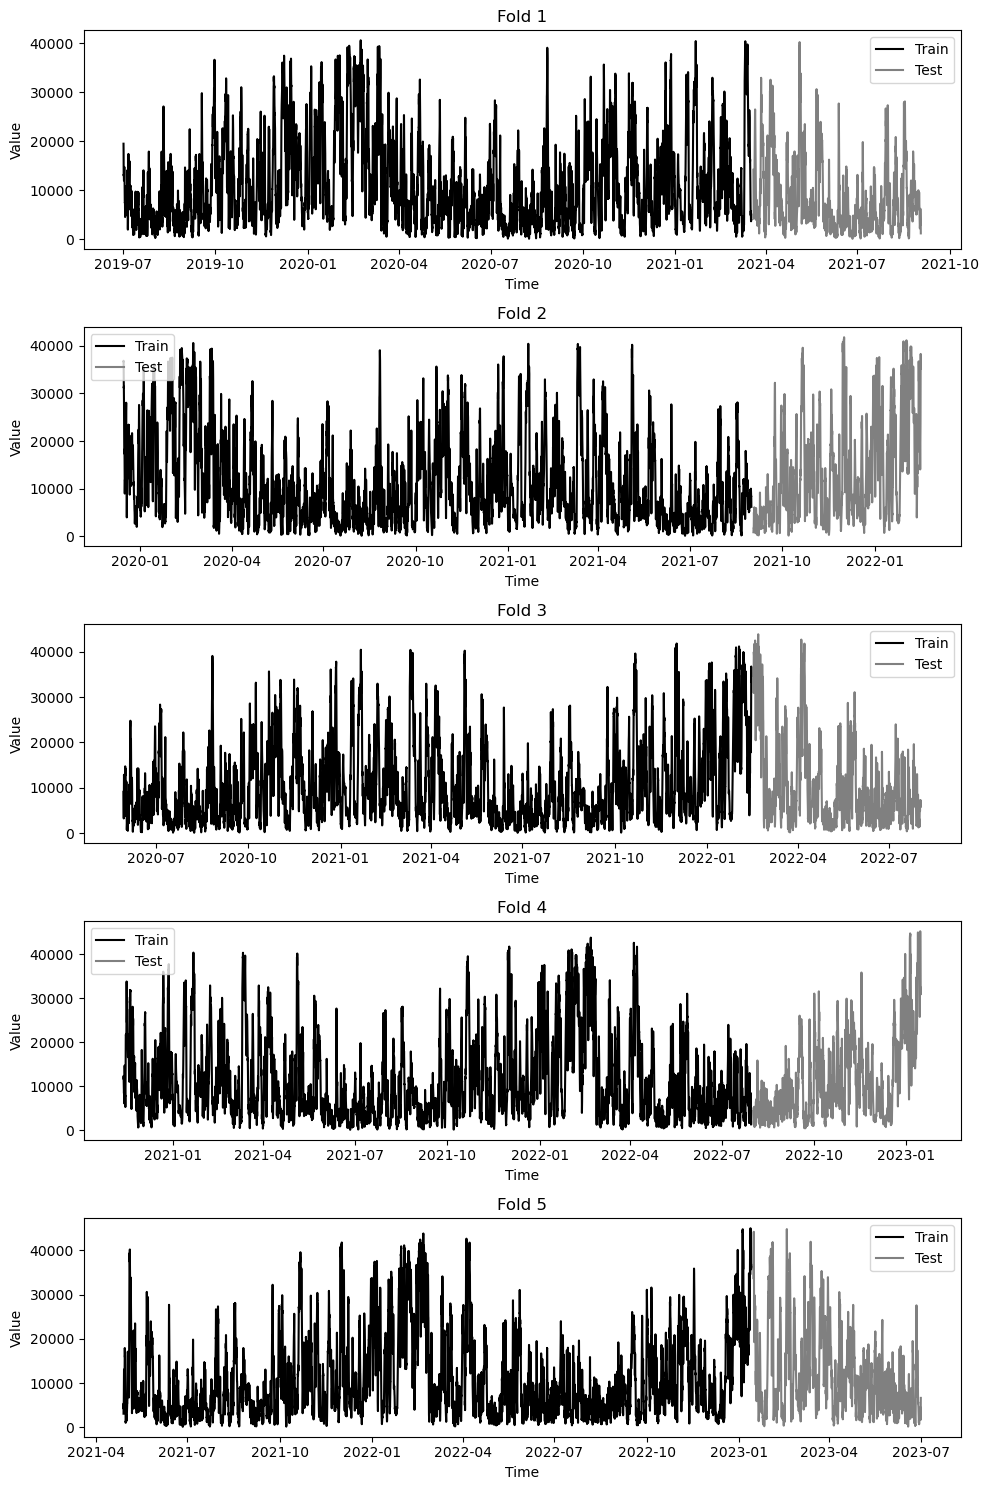

In [155]:
n_splits = 5
tscv = TimeSeriesSplit(
    n_splits=n_splits,
    gap=48,
    max_train_size=15_000,
    test_size=4_000
)

fig, axes = plt.subplots(n_splits, figsize=(10, 15))

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    ax = axes[i]
    
    ax.plot(y.index[train_index], y.iloc[train_index], 'black', label='Train')
    ax.plot(y.index[test_index], y.iloc[test_index], 'grey', label='Test')
    
    ax.legend()
    ax.set_title(f"Fold {i+1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

plt.tight_layout()
plt.show()

In [143]:
df['actual_generated_smard_mwh'].describe()

count    48168.000000
mean     11193.426461
std       8992.759097
min        100.250000
25%       4245.875000
50%       8473.000000
75%      15918.500000
max      45285.250000
Name: actual_generated_smard_mwh, dtype: float64

In [135]:
# test_size defaults to n_samples // (n_splits + 1)
ts_cv = TimeSeriesSplit(
    n_splits=5,
)

In [136]:
# list of tuples
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[1]

In [137]:
all_splits[0][0]

array([   0,    1,    2, ..., 8025, 8026, 8027])

In [142]:
X.loc[all_splits[1][1]]

KeyError: "None of [Index([16056, 16057, 16058, 16059, 16060, 16061, 16062, 16063, 16064, 16065,\n       ...\n       24074, 24075, 24076, 24077, 24078, 24079, 24080, 24081, 24082, 24083],\n      dtype='int64', name='datetime_utc', length=8028)] are in the [index]"

------

#### The below doesn't work as I have multiple features in X!

In [84]:
train = df.loc[df.index < '2023-01-01']
test = df.loc[df.index >= '2023-01-01']

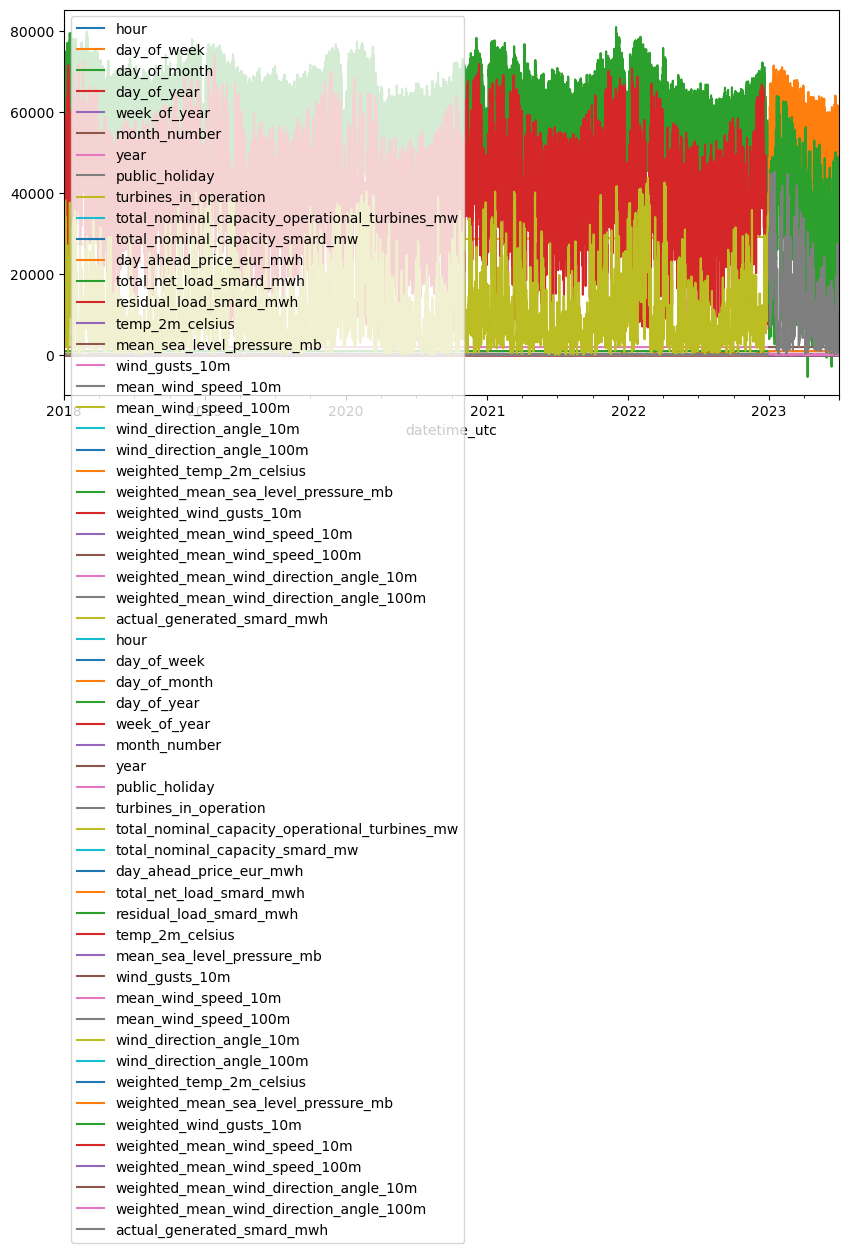

In [85]:
fig, ax = plt.subplots(figsize=(10,5))
train.plot(ax=ax, label='training set')
test.plot(ax=ax, label='test set')
plt.show()